In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try :
  from einops import rearrange
except ModuleNotFoundError :
  !pip install einops
  from einops import rearrange

In [4]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [5]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
img.shape

torch.Size([3, 1365, 2048])

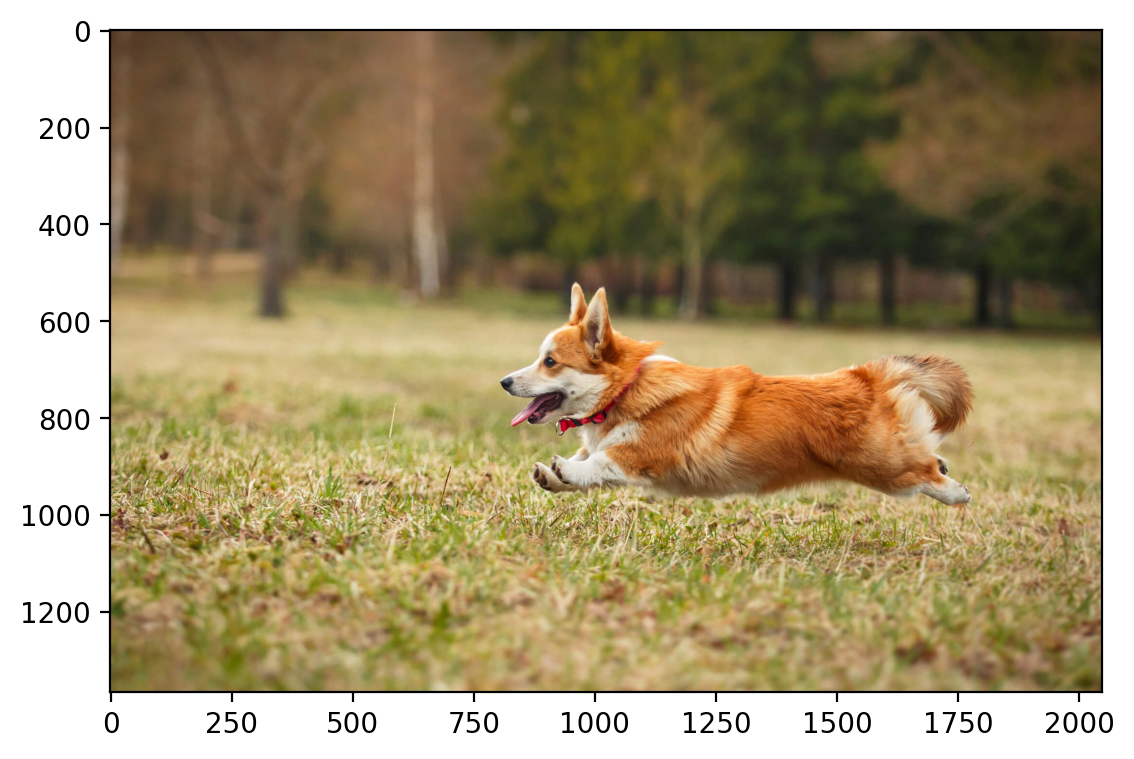

In [6]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [7]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [8]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)

img_scaled = torch.tensor(img_scaled)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [9]:
img_scaled = img_scaled.to(device)
img_scaled.shape

torch.Size([3, 1365, 2048])

In [10]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 150, 150)
crop.shape

torch.Size([3, 150, 150])

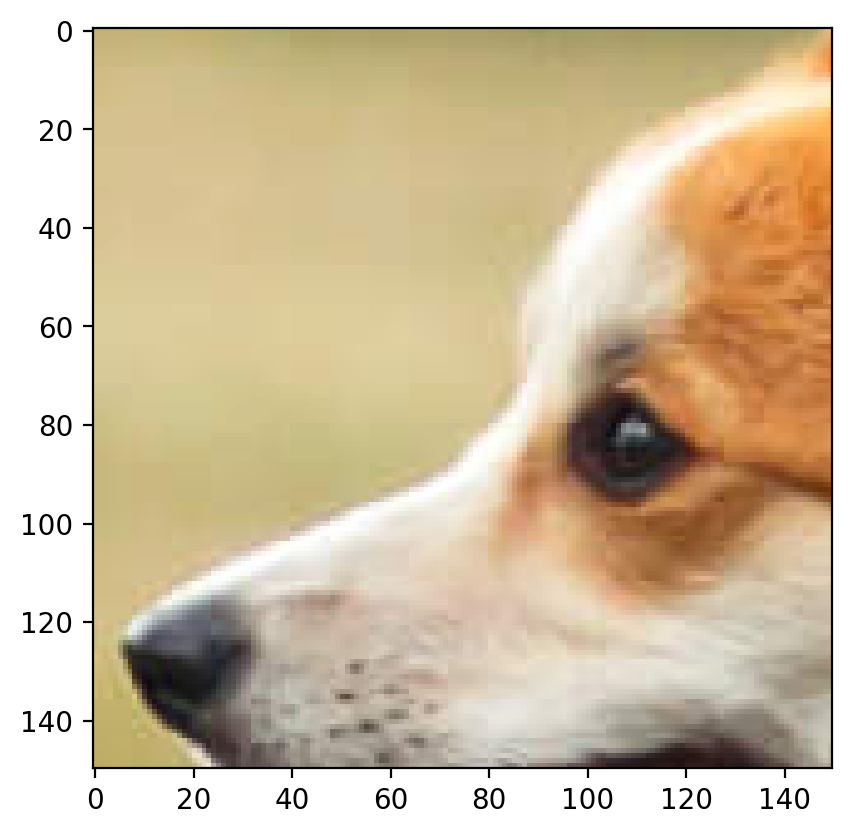

In [11]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [12]:
crop = crop.to(device)

In [13]:
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 150 150


In [14]:
def create_coordinate_map(img, scale=1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()

    # Move X to GPU if available
    Y = Y.to(device)

    return X, Y

In [15]:
dog_X, dog_Y = create_coordinate_map(crop, scale=2)

dog_X.shape, dog_Y.shape

(torch.Size([90000, 2]), torch.Size([22500, 3]))

In [16]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())

# Scale the X coordinates
dog_X_scaled = scaler_X.transform(dog_X.cpu())

# Move the scaled X coordinates to the GPU
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.float()

In [17]:
# create RFF features
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [18]:
X_rff = create_rff_features(dog_X_scaled, 15000, 0.008)

In [19]:
arr = np.array([False for _ in range(len(X_rff)//2)])
for i in range(width) :
    arr[2*width*i:2*width*i+width] = True
sum(arr)

22500

In [20]:
X_train = X_rff[::2][arr]
X_train.shape

torch.Size([22500, 15000])

In [21]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [22]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")

    return loss.item()

In [23]:
net = LinearModel(X_train.shape[1], 3)
net.to(device)

train(net, 0.005, X_train, dog_Y, 2500)

Epoch 0 loss: 0.491968
Epoch 100 loss: 0.087641
Epoch 200 loss: 0.019292
Epoch 300 loss: 0.010530
Epoch 400 loss: 0.008151
Epoch 500 loss: 0.006746
Epoch 600 loss: 0.005718
Epoch 700 loss: 0.004910
Epoch 800 loss: 0.004250
Epoch 900 loss: 0.003699
Epoch 1000 loss: 0.003235
Epoch 1100 loss: 0.002839
Epoch 1200 loss: 0.002500
Epoch 1300 loss: 0.002208
Epoch 1400 loss: 0.001956
Epoch 1500 loss: 0.001738
Epoch 1600 loss: 0.001548
Epoch 1700 loss: 0.001382
Epoch 1800 loss: 0.001237
Epoch 1900 loss: 0.001109
Epoch 2000 loss: 0.000996
Epoch 2100 loss: 0.000896
Epoch 2200 loss: 0.000807
Epoch 2300 loss: 0.000727
Epoch 2400 loss: 0.000656


0.0005932752974331379

In [24]:
def plot_reconstructed_and_original_image(original_img, net, X_train, X, title="", scale=1):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():

        outputs = net(X_train)
        outputs = outputs.reshape(height, width, num_channels)

    fig = plt.figure(figsize=(9, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


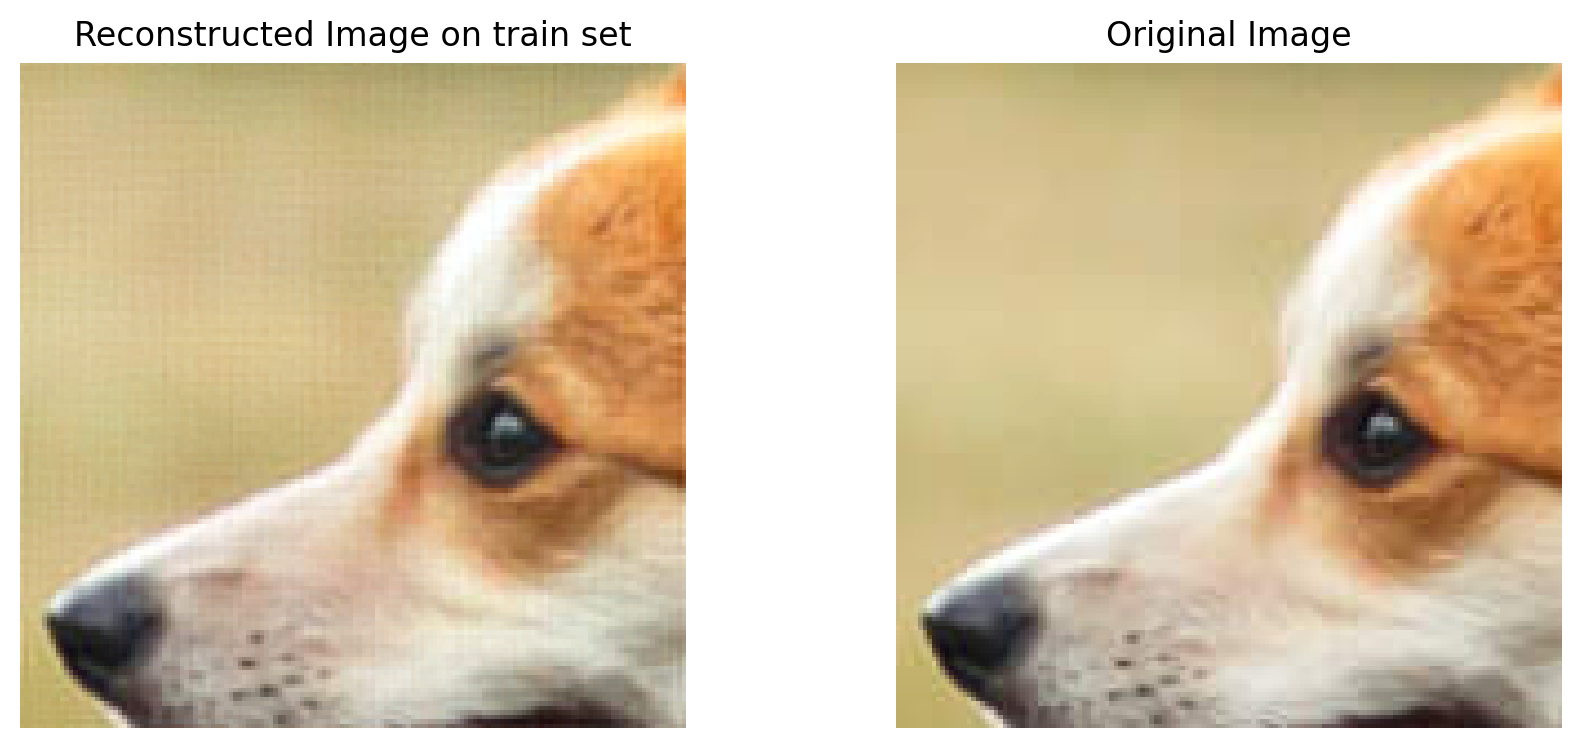

In [25]:
plot_reconstructed_and_original_image(crop, net, X_train, X_rff, scale=2)